#**Brain Cancer Classification**

#**All General Imports**

In [2]:
# imports
import os
import sys
import timeit
import platform 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from sklearn.model_selection import train_test_split

#**All Keras Imports**

In [3]:
from tensorflow.keras.models import save_model, Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Dropout, concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

#**All Functions Definitions**

In [4]:
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

#**All Data Downloads**

In [5]:
start_time = timeit.default_timer()
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

os.system('pip install --upgrade --no-cache-dir gdown')

out = data_download("./brain_tumor_dataset_1.zip", "1IlfIKVCF2nnYndfZWsE7NHPE0si2bof1", OS)
out = data_download("./brain_tumor_dataset_2.zip", "1dYZ4GMfSeCEdnw-JqlgNUsMajHzLCqWp", OS)
print("Elapsed Time: ", timeit.default_timer() - start_time)

Elapsed Time:  16.082199537000008


#**Brain Tumor Classification**

#**All Globals**

In [6]:
negative_dataset_path_1 = "./brain_tumor_dataset_1/no/"
positive_dataset_path_1 = "./brain_tumor_dataset_1/yes/"
negative_dataset_path_2 = "./brain_tumor_dataset_2/no/"
positive_dataset_path_2 = "./brain_tumor_dataset_2/yes/"

dataset_path = [positive_dataset_path_1, negative_dataset_path_1, positive_dataset_path_2, negative_dataset_path_2]
data_type = "float"

#**Hyperparameters**

In [7]:
neural_model = 'brain_net'
transfer_learning = True
epochs = 30
batch_size = 32
width = 256
height = 256
channels = 1
summary = True
val_set_rate = 0.1
test_set_rate = 0.1

#**Initializations**

In [8]:
np.random.seed(42)
dataset = []
labels = []

#**Preprocessing**

In [9]:
for dp in dataset_path:  
  images = glob.glob(dp + "*.jpg")
  images.sort()
  if "/yes" in dp: 
    label = 1               # tumor patient
  elif "/no" in dp: 
    label = 0               # healthy patient 
  for x in images:
    image = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    image = image / 255
    image = cv2.resize(image, (width, height))
    dataset.append(image)
    labels.append(label)

dataset = np.asarray(dataset).astype(data_type)
labels = np.asarray(labels).astype("int")
print("Dataset Shape: ", dataset.shape)
print("Labels Shape: ", labels.shape)

Dataset Shape:  (3171, 256, 256)
Labels Shape:  (3171,)


In [10]:
print(labels)

[1 1 1 ... 0 0 0]


#**Data Shuffle**

In [11]:
indices = np.arange(dataset.shape[0])
np.random.shuffle(indices)
dataset = dataset[indices]
labels = labels[indices]

In [12]:
print(labels)

[1 0 1 ... 1 1 1]


#**Dataset Sample Visualization**

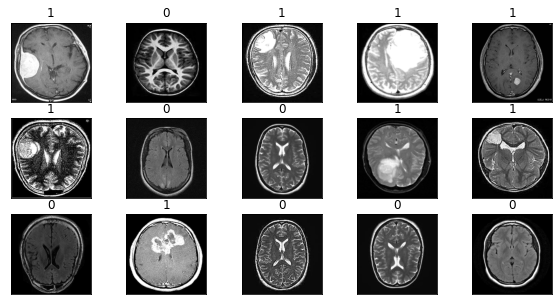

In [13]:
fig = plt.figure(figsize=(10,5))
for i in range(15): 
    ax = fig.add_subplot(3, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(labels[i])
    plt.imshow(dataset[i], cmap = "gray")
plt.show()

#**Train-Val-Test Split**

In [14]:
train_x, val_x, train_y, val_y = train_test_split(dataset, labels, test_size=val_set_rate)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=test_set_rate)

print("Train X Shape: ", train_x.shape)
print("Train Y Shape: ", train_y.shape)
print("Val X Shape: ", val_x.shape)
print("Val Y Shape: ", val_y.shape)
print("Test X Shape: ", test_x.shape)
print("Test Y Shape: ", test_y.shape)

Train X Shape:  (2567, 256, 256)
Train Y Shape:  (2567,)
Val X Shape:  (318, 256, 256)
Val Y Shape:  (318,)
Test X Shape:  (286, 256, 256)
Test Y Shape:  (286,)


#**Model Definitions**

In [15]:
class AvancedBrainModel:
  
  @staticmethod
  def build(neural_model, transfer_learning, model_input_width, model_input_height, input_channels, summary):
      if transfer_learning is True: 
        pretrained_weights = "imagenet"
      else: 
        pretrained_weights = None
      
      if neural_model == 'xception':
          deep_network = Xception(weights=pretrained_weights, include_top=False, input_tensor=Input(shape=(model_input_width, model_input_height, input_channels)))
      elif neural_model == 'resnet':
          deep_network = ResNet50(weights=pretrained_weights, include_top=False, input_tensor=Input(shape=(model_input_width, model_input_height, input_channels)))
      elif neural_model.lower() == 'mobilenet':
          deep_network = MobileNet(weights=pretrained_weights, include_top=False, input_tensor=Input(shape=(model_input_width, model_input_height, input_channels)))
      elif neural_model.lower() == 'inceptionresnet':
          deep_network = InceptionResNetV2(weights=pretrained_weights, include_top=False, input_tensor=Input(shape=(model_input_width, model_input_height, input_channels)))
      elif neural_model.lower() == 'brain_net': 
          deep_network = Sequential()
          deep_network.add(Conv2D(32, 4, activation = 'relu', padding = 'same', input_shape=(model_input_width, model_input_height, input_channels)))
          deep_network.add(MaxPooling2D(pool_size=(2, 2)))
          deep_network.add(Dropout(0.5))
          deep_network.add(Conv2D(32, 4, activation = 'relu', padding = 'same'))
          deep_network.add(MaxPooling2D(pool_size=(2, 2)))
          deep_network.add(Dropout(0.3))
          deep_network.add(Conv2D(64, 4, activation = 'relu', padding = 'same'))
          deep_network.add(MaxPooling2D(pool_size=(2, 2)))
          deep_network.add(Dropout(0.3))
          deep_network.add(Flatten())
          deep_network.add(Dense(128, activation='relu'))
          deep_network.add(Dropout(0.15))
          deep_network.add(Dense(1, activation='sigmoid'))
      else: 
          print("Neural Model not supported: ", neural_model)
          return None    

      if neural_model.lower() != 'brain_net': 
        x = deep_network.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256,activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(1, activation='sigmoid')(x)

        deep_network = Model(inputs=deep_network.input, outputs=predictions)

      if summary==True:
          deep_network.summary()

      # return the constructed network architecture
      return deep_network

#**Brain Tumor Classifier Compiling**

In [16]:
brain_tumor_model = AvancedBrainModel.build(neural_model, transfer_learning, width, height, channels, summary)
brain_tumor_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0

#**Brain Model Training**

In [17]:
history = brain_tumor_model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs = epochs, batch_size = batch_size, verbose=1)

Epoch 1/30
81/81 [==============================] - 27s 170ms/step - loss: 0.5600 - accuracy: 0.7480 - val_loss: 0.4796 - val_accuracy: 0.8522
Epoch 2/30
81/81 [==============================] - 13s 155ms/step - loss: 0.3285 - accuracy: 0.8598 - val_loss: 0.2784 - val_accuracy: 0.8836
Epoch 3/30
81/81 [==============================] - 13s 155ms/step - loss: 0.1942 - accuracy: 0.9272 - val_loss: 0.2393 - val_accuracy: 0.9245
Epoch 4/30
81/81 [==============================] - 12s 150ms/step - loss: 0.1095 - accuracy: 0.9642 - val_loss: 0.1904 - val_accuracy: 0.9465
Epoch 5/30
81/81 [==============================] - 12s 151ms/step - loss: 0.0637 - accuracy: 0.9778 - val_loss: 0.1963 - val_accuracy: 0.9465
Epoch 6/30
81/81 [==============================] - 12s 152ms/step - loss: 0.0490 - accuracy: 0.9825 - val_loss: 0.1826 - val_accuracy: 0.9591
Epoch 7/30
81/81 [==============================] - 12s 153ms/step - loss: 0.0252 - accuracy: 0.9914 - val_loss: 0.1997 - val_accuracy: 0.9717

In [19]:
# save the model
save_model(brain_tumor_model, './brain_cancer_model.h5')

#**Brain Cancer Model Evaluation**

In [20]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


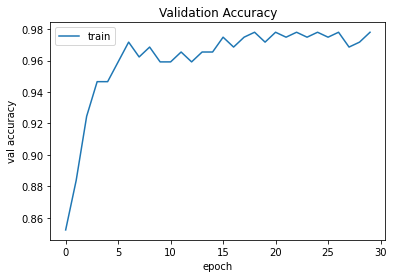

In [28]:
# summarize history for accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

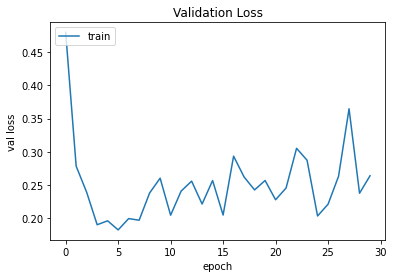

In [29]:
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [30]:
score = brain_tumor_model.evaluate(test_x, test_y, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9825174808502197


#**Inclass Exercises and Homeworks**

0) Make a pre and post Data Exploratory Analysis

1) Add all checkpoints to find the best model

2) Visualize internals of CNN with: Feature Map Visualizatio, Filter Visualization

3) Check if the model on some test images highlight the cancer with a segmentation-like process with Grad-Cam 

4) Try to optimize the well-known models (resnet, inception, etc.) or the brain-net to get the best accuracy ever on the validation / test set

5) Train with TPU

6) Make some Data Augmentation and all needed regularizations